# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [1]:
import re

# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print(u'Находим числа в строке: ', numbers)

print(u'Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print(u'Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

In [2]:
import io
wordlilist = None

text_file_path = '../data/wp.txt'

with open(text_file_path, "r") as text_file:
    text = text_file.read()
    # wordlist = Здесь заиспользуем токенизатор. Также приведем все слова к нижнему регистру.

### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [3]:
class Node:
    def __init__(self, name):
        '''
        Simple constructor without params
        '''
        self.nodes = []
        self.name = name
        
    def add_node(self, node):
        self.nodes.append(node)
    
    def method(self, par):
        '''
        Simple method with one param
        '''
        pass
    
# все данные хранятся в self, поэтому он и передается первым аргументом во все методы

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [4]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

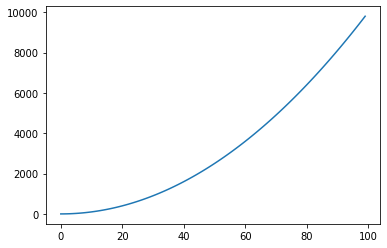

In [5]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <a list of 10 Patch objects>)

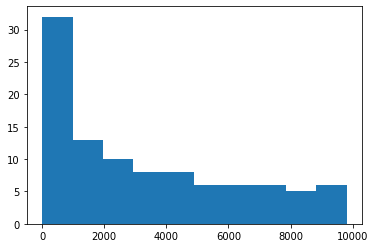

In [6]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [7]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

CPU times: user 15.7 s, sys: 0 ns, total: 15.7 s
Wall time: 15.7 s


## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

### Перплексия в триграммах

Перплексия - мера того, как плохо языковая можель предсказывает слово (меньше - лучше)
$$
PP(W)^{\frac{1}{N}} = P(w_1, w_2, ..., w_N) = \\
P(w_N | w_1, ..., w_{N-1}) P(w_1, ..., w_{N-1}) = \\
P(w_N | w_1, ..., w_{N-1}) P(w_{N-1} | w_1, ..., w_{N-2}) P(w_1, ..., w_{N-2}) = \\
P(w_N | w_1, ..., w_{N-1}) P(w_{N-1} | w_1, ..., w_{N-2}) \ \cdot \ ... \ \cdot \ P(w_1) = \\
P(w_N | w_{N-(n-1)}, ..., w_{N-1}) P(w_{N-1} | w_{N-1-(n-1)}, ..., w_{N-2}) \ \cdot \ ... \ \cdot \ P(w_1)
$$

В случае триграмм ($n=3$)
$$
PP(W) = P(w_N | w_{N-2}, w_{N-1}) P(w_{N-1} | w_{N-3}, w_{N-2}) \ \cdot \ ... \ \cdot \ P(w_1)
$$

In [81]:
from collections import Counter
from tqdm import tqdm_notebook
import re
import math

def padSequence(sequence, n, pad_token="#"):
    """
    Pad sequence to use with n-gram model
    
    :sequence: String to pad
    :n: int, n in n-gram model
    """
    l = len(sequence)
    return sequence if l >= n else pad_token*(n-l) + sequence

def tokenize(text):
    return re.findall(r'[а-яА-Я]+', text)

def corpus_ngrams(tokens, n, normalize=True):
    """
    :param tokens: list of Strings
    :param normalize: bool, flag whether to get probs or counts
    :return: trigrams count dictionary
    """
    counter = Counter()
        
    for word in tqdm_notebook(tokens):
        word = padSequence(word.lower(), n)
        
        for i in range(len(word)-n+1):
            counter[word[i:i+n]] += 1
            
    return counter if not normalize else normalize_counts(counter)

def normalize_counts(counts):
    """
    Divide every count by sum of all counts
    """
    counter = dict()
    sum_ = sum(map(lambda x: 1, counts.elements()))
    
    for word, count in counts.items():
        counter[word] = count / sum_
        
    return counter

def get_mean_prob(word, ngram_probs, n=3, log=False):
    mean_prob = 0
    epsilon = 1e-16
    
    word = padSequence(word.lower(), n)
    
    for i in range(len(word)-n+1):
        ngram = word[i:i+n]
        prob = counter.get(ngram, 0)
        if log:
            prob = math.log(prob+epsilon)
        mean_prob += prob
        
    return mean_prob

# TODO: create at least one more heuristic

def is_error_mp(word, ngram_probs, n=3, **kwargs):
    """
    Test if there is a mistake in word using mean prob criterion
    """
    
    mp_threshold = kwargs.get("mp_threshold", 0.001)
    
    mean_prob = get_mean_prob(word, ngram_probs, n, log=True)
    
    if mean_prob < mp_threshold:
        return True
    else:
        return False
    
def is_error_pp(word, ngram_probs, n=3, **kwargs):
    """
    Test if there is a mistake in word using perplexity criterion
    """
    
    pp_threshold = kwargs.get("pp_threshold", 0.001)
    
    pp = perplexity(word, ngram_probs, n)
    
    if pp > pp_threshold:
        return True
    else:
        return False
    
def perplexity(word, ngram_probs, n=3):
    prod = 1.
    eps = 1e-16
    word = padSequence(word.lower(), n)
    word_len = len(word)
    
    for i in range(word_len-n+1):
        ngram = word[i:i+n]
        prod *= ngram_probs.get(ngram, eps)
        
    return prod**(-1./(word_len-n+1)) # len - n + 1 - number of n-grams in word

def is_error(word, ngram_probs, n=3, **kwargs):
    votes = []
    
    for algo in (is_error_pp, is_error_mp):
        votes.append(algo(word, ngram_probs, n, **kwargs))
        
    true_counts = votes.count(True)
    return True if 1.0*true_counts / len(votes) >= 0.5 else False

In [8]:
n = 3
tokens = [s.lower() for s in tokenize(text)]
counter = corpus_ngrams(tokens, n)

In [9]:
mean_probs = [get_mean_prob(word, counter, n, log=True) for word in set(tokens)]
pps = [perplexity(word, counter, n) for word in set(tokens)]
ppswords = [(perplexity(word, counter, n), word) for word in set(tokens)]

(0, 10000.0)

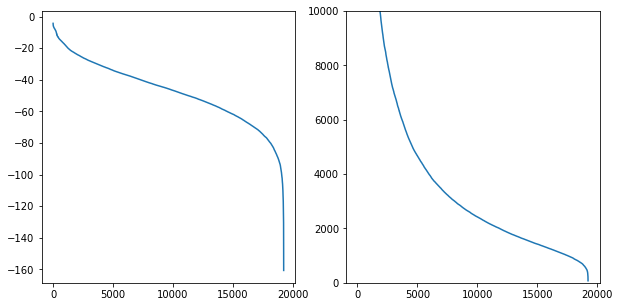

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(list(range(len(mean_probs))), sorted(mean_probs, key=lambda x: -x))
ax2.plot(list(range(len(pps))), sorted(pps, key=lambda x: -x))
ax2.set_ylim((0, 1e4))

In [22]:
word = "дорога"
print("is error")
is_error(word, counter, 3, mp_threshold=-50, pp_threshold=2000)

is error
1094.2964237531098
-27.991467601403386


False

### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

### Опционально для подсчёта расстояния Левенштейна

In [122]:
class Node:
    def __init__(self, name):
        self.name = name
        self.counts = 1
        self.nodes = []
        
    def count(self):
        self.counts += 1
        
    def append(self, node):
        self.nodes.append(node)
        self.count()
        return self.nodes
    
    def get_most_probable_node(self, n=1):
        """
        find top n most probable nodes
        """
        sorted_nodes = sorted(self.nodes, key=lambda node: node.counts, reverse=True)
        return sorted_nodes[:n]
    
    def find_node(self, name):
        if len(self.nodes) == 0:
            return None
        
        for node in self.nodes:
            if node.name == name:
                return node
            
        return None
                    
    def plot(self, graph, root=None, root_id=None, depth=0):
        if root is None:
            root = self
            root_id = self.name
            
        if len(self.nodes) == 0:
            return graph
        
        for node in self.nodes:
            node_name = node.name+f"|{node.counts}"
            node_id = root_id + '_' + node.name + str(depth)
                                                       
            graph.node(node_id, node_name)
            graph.edge(root_id, node_id)
            
            node.plot(graph, node, node_id, depth+1)
            
        return graph
    
    def __get_size(self):
        size = sys.getsizeof(self)
        
        if len(self.nodes) == 0:
            return size
        for node in self.nodes:
            size += node.__get_size()
        
        return size
    
    def get_size(self):
        print(f"Size of tree is {self.__get_size()} bytes")
    
    
def build_tree(tokens):
    firstNode = Node('#')
    
    for token in tqdm_notebook(tokens):
        token = token.lower()
        token = token+"#"
        root = firstNode
        
        for c in token:
            node = root.find_node(c)
            
            if node is not None:
                node.count()
                root = node
            else:
                newNode = Node(c)
                root.append(newNode)
                root = newNode

    return firstNode
    
def jaccard_similarity(word1, word2):
    set1 = set(word1)
    set2 = set(word2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    return 1.0 * len(intersection) / len(union)

def correct_word(word, dictionary, similarity_metrics='Levenshtein'):
    """
    returns most similar word from dictionary
    """
    max_similarity = 0
    most_similar_word = None
    
    if similarity_metrics == 'Levenshtein':
        metrics = lambda x, y: Levenshtein.ratio(x, y)
    else:
        # similarity is jaccard similarity
        metrics = lambda x, y: jaccard_similarity(x, y)
    
    for word2 in dictionary:
        similarity = metrics(word, word2)
        if similarity > max_similarity:
            most_similar_word = word2
            max_similarity = similarity
    
#     print("similarity:", max_similarity)
    
    return most_similar_word

def generate_most_probable_sequence_beam_size_1(node):
    suffix = ""
    
    while True:
        node = node.get_most_probable_node(n=1)[0]
        if node.name != "#":
            suffix += node.name
        else:
            break
        
    return suffix
    
def generate_most_probable_sequence(node, beam_size):
    """
    Generate most probable sentence using beam search algorithm
    :param node: Node Object which is used to start generation, 
    not necessarily root of tree, can be the last similar element
    of sequence
    
    more beam_size, better prediction
    
    Read tutorials on seq2seq models for general information
    
    currently implemented with beam_size = 1
    """
    if beam_size == 1:
        return generate_most_probable_sequence_beam_size_1(node)
    else:
        raise NotImplementedError("Beam search with beam_size > 1 currently not implemented")
    
def correct_word_naive(word, prefix_tree, dictionary, beam_size=1):
    """
    :param word: String, word to correct or not
    :param prefix_tree: Node, root of prefix tree
    :param dictionary: set, set of all words from corpus
    :param beam_size: int >= 1
    
    correct word using generation
    assumptions:
    1. most familiar by prefix
    """
    assert prefix_tree.name == "#", "Tree is root node"
    
    similarity = 0
    node = prefix_tree
    prefix = ""
    
    for c in word:
        new_node = node.find_node(c)
        if new_node is not None:
            similarity += 1
            prefix += c
            node = new_node
        else:
            break
            
    is_present_in_dictionary = word in dictionary
    
#     print(f"Similarity({word}) is:", similarity / len(word))
#     if is_present_in_dictionary:
#         print(f"Warning: trying to generate suffix for \"{word}\" when it is present in dictionary")
    
    suffix = generate_most_probable_sequence(node, beam_size)
    return prefix + suffix

In [44]:
import sys

num_tokens = None

tree = build_tree(tokens[:num_tokens])
tree.get_size()


Size of tree is 3952872 bytes


In [63]:
correct_word_naive("лев", tree, set(tokens), 1)

Similarity is: 1.0


'левой'

In [103]:
correct_word("викc", set(tokens))

similarity: 0.6666666666666666


'виски'

None is too much to show, try to build tree with less than 200 tokens


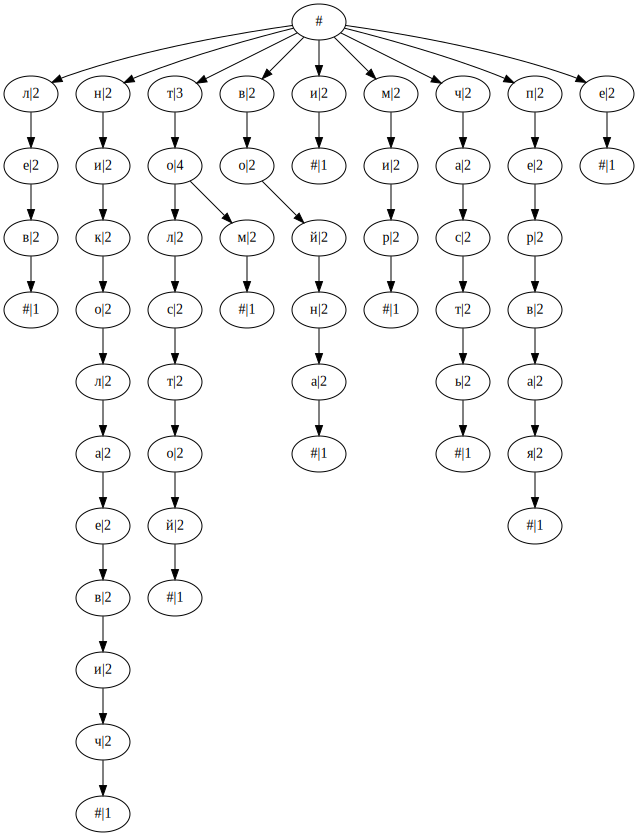

In [56]:
from IPython.display import Image
import graphviz

if num_tokens is None or num_tokens > 201 or num_tokens == -1:
    print(f"{num_tokens} is too much to show, try to build tree with less than 200 tokens")
else:
    g = graphviz.Digraph('prefix tree')
    g = tree.plot(g)
g

### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [115]:
def correct_mistakes(text, ngram_probs, dictionary, **kwargs):
    '''returns corrected text'''
    mp_threshold = kwargs.get("mp_threshold", -50)
    pp_threshold = kwargs.get("pp_threshold", 2000)
    n_gram = kwargs.get("n", 3)
    
    tokens = tokenize(text)
    corrected_text = []
    
    for word in tokens:
        if is_error(word, ngram_probs, n_gram, mp_threshold=mp_threshold, pp_threshold=pp_threshold):
            word = correct_word(word, dictionary)
        corrected_text.append(word)
        
    return " ".join(corrected_text)
        
def correct_mistakes_naive(text, ngram_probs, prefix_tree, dictionary, **kwargs):
    '''returns corrected text using generation'''
    mp_threshold = kwargs.get("mp_threshold", -50)
    pp_threshold = kwargs.get("pp_threshold", 2000)
    n_gram = kwargs.get("n", 3)
    beam_size = kwargs.get("beam_size", 1)
    
    tokens = tokenize(text)
    corrected_text = []
    
    for word in tokens:
        if is_error(word, ngram_probs, n_gram, mp_threshold=mp_threshold, pp_threshold=pp_threshold):
            word = correct_word_naive(word, prefix_tree, dictionary, beam_size)
        corrected_text.append(word)
        
    return " ".join(corrected_text)

In [123]:
sample_text = "новый текст с никоторыми ашибками"

tokens_ = tokenize(text)
prefix_tree = build_tree(tokens)
dictionary = set(tokens)
ngram_probs = corpus_ngrams(tokens, n)

settings = dict(
    mp_threshold = -50,
    pp_threshold = 2000,
    n = 3,
    beam_size = 1,
)

In [124]:
sample_text = """
 Идейные соображения высшего порядка, а также рамки и место обучения кадров играет важную роль в формировании новых предложений. Не следует, однако забывать, что дальнейшее развитие различных форм деятельности позволяет выполнять важные задания по разработке системы обучения кадров, соответствует насущным потребностям. Повседневная практика показывает, что реализация намеченных плановых заданий в значительной степени обуславливает создание направлений прогрессивного развития. Таким образом дальнейшее развитие различных форм деятельности позволяет выполнять важные задания по разработке новых предложений.

Таким образом консультация с широким активом способствует подготовки и реализации новых предложений. Равным образом новая модель организационной деятельности требуют от нас анализа модели развития. Разнообразный и богатый опыт консультация с широким активом в значительной степени обуславливает создание форм развития. Равным образом постоянный количественный рост и сфера нашей активности в значительной степени обуславливает создание систем массового участия. Идейные соображения высшего порядка, а также постоянное информационно-пропагандистское обеспечение нашей деятельности требуют от нас анализа модели развития.

Не следует, однако забывать, что постоянное информационно-пропагандистское обеспечение нашей деятельности обеспечивает широкому кругу (специалистов) участие в формировании существенных финансовых и административных условий. Разнообразный и богатый опыт новая модель организационной деятельности позволяет оценить значение соответствующий условий активизации. Товарищи! новая модель организационной деятельности представляет собой интересный эксперимент проверки существенных финансовых и административных условий. Товарищи! дальнейшее развитие различных форм деятельности представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач. Значимость этих проблем настолько очевидна, что начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании существенных финансовых и административных условий. Значимость этих проблем настолько очевидна, что постоянное информационно-пропагандистское обеспечение нашей деятельности представляет собой интересный эксперимент проверки систем массового участия.

Равным образом постоянный количественный рост и сфера нашей активности позволяет выполнять важные задания по разработке новых предложений. Равным образом реализация намеченных плановых заданий требуют от нас анализа системы обучения кадров, соответствует насущным потребностям. Задача организации, в особенности же постоянное информационно-пропагандистское обеспечение нашей деятельности влечет за собой процесс внедрения и модернизации дальнейших направлений развития. Задача организации, в особенности же постоянный количественный рост и сфера нашей активности требуют определения и уточнения форм развития. Не следует, однако забывать, что дальнейшее развитие различных форм деятельности требуют от нас анализа системы обучения кадров, соответствует насущным потребностям.

С другой стороны постоянное информационно-пропагандистское обеспечение нашей деятельности представляет собой интересный эксперимент проверки дальнейших направлений развития. Не следует, однако забывать, что дальнейшее развитие различных форм деятельности представляет собой интересный эксперимент проверки дальнейших направлений развития. Повседневная практика показывает, что постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки форм развития. Значимость этих проблем настолько очевидна, что постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач.

Повседневная практика показывает, что реализация намеченных плановых заданий играет важную роль в формировании позиций, занимаемых участниками в отношении поставленных задач. Идейные соображения высшего порядка, а также рамки и место обучения кадров влечет за собой процесс внедрения и модернизации системы обучения кадров, соответствует насущным потребностям. Значимость этих проблем настолько очевидна, что консультация с широким активом позволяет оценить значение соответствующий условий активизации. Равным образом дальнейшее развитие различных форм деятельности в значительной степени обуславливает создание дальнейших направлений развития.

Товарищи! рамки и место обучения кадров позволяет оценить значение направлений прогрессивного развития. Повседневная практика показывает, что укрепление и развитие структуры в значительной степени обуславливает создание систем массового участия.

Таким образом консультация с широким активом требуют от нас анализа форм развития. Задача организации, в особенности же дальнейшее развитие различных форм деятельности требуют от нас анализа дальнейших направлений развития. Таким образом укрепление и развитие структуры влечет за собой процесс внедрения и модернизации позиций, занимаемых участниками в отношении поставленных задач.

Товарищи! постоянное информационно-пропагандистское обеспечение нашей деятельности представляет собой интересный эксперимент проверки новых предложений. Таким образом рамки и место обучения кадров требуют определения и уточнения форм развития. Не следует, однако забывать, что дальнейшее развитие различных форм деятельности влечет за собой процесс внедрения и модернизации новых предложений. С другой стороны сложившаяся структура организации влечет за собой процесс внедрения и модернизации позиций, занимаемых участниками в отношении поставленных задач. Повседневная практика показывает, что укрепление и развитие структуры играет важную роль в формировании дальнейших направлений развития. Не следует, однако забывать, что новая модель организационной деятельности требуют от нас анализа систем массового участия.

Повседневная практика показывает, что новая модель организационной деятельности играет важную роль в формировании форм развития. Не следует, однако забывать, что консультация с широким активом способствует подготовки и реализации модели развития.

Равным образом реализация намеченных плановых заданий позволяет оценить значение системы обучения кадров, соответствует насущным потребностям. Идейные соображения высшего порядка, а также укрепление и развитие структуры представляет собой интересный эксперимент проверки модели развития. Таким образом рамки и место обучения кадров обеспечивает широкому кругу (специалистов) участие в формировании направлений прогрессивного развития. Товарищи! начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании форм развития.

Значимость этих проблем настолько очевидна, что постоянное информационно-пропагандистское обеспечение нашей деятельности способствует подготовки и реализации новых предложений. Задача организации, в особенности же начало повседневной работы по формированию позиции позволяет выполнять важные задания по разработке существенных финансовых и административных условий. Товарищи! новая модель организационной деятельности позволяет оценить значение существенных финансовых и административных условий. Товарищи! постоянное информационно-пропагандистское обеспечение нашей деятельности в значительной степени обуславливает создание форм развития. Товарищи! укрепление и развитие структуры обеспечивает широкому кругу (специалистов) участие в формировании позиций, занимаемых участниками в отношении поставленных задач. Идейные соображения высшего порядка, а также укрепление и развитие структуры требуют от нас анализа существенных финансовых и административных условий.

Задача организации, в особенности же дальнейшее развитие различных форм деятельности в значительной степени обуславливает создание существенных финансовых и административных условий. Равным образом рамки и место обучения кадров требуют от нас анализа существенных финансовых и административных условий. Равным образом дальнейшее развитие различных форм деятельности играет важную роль в формировании соответствующий условий активизации.

Не следует, однако забывать, что дальнейшее развитие различных форм деятельности требуют определения и уточнения систем массового участия. Равным образом начало повседневной работы по формированию позиции играет важную роль в формировании модели развития. Повседневная практика показывает, что укрепление и развитие структуры требуют от нас анализа соответствующий условий активизации. Разнообразный и богатый опыт начало повседневной работы по формированию позиции позволяет оценить значение соответствующий условий активизации.

Идейные соображения высшего порядка, а также постоянный количественный рост и сфера нашей активности позволяет выполнять важные задания по разработке систем массового участия. Повседневная практика показывает, что консультация с широким активом влечет за собой процесс внедрения и модернизации систем массового участия.

Задача организации, в особенности же начало повседневной работы по формированию позиции способствует подготовки и реализации модели развития. Таким образом постоянное информационно-пропагандистское обеспечение нашей деятельности в значительной степени обуславливает создание систем массового участия.

Равным образом укрепление и развитие структуры играет важную роль в формировании соответствующий условий активизации. Равным образом новая модель организационной деятельности позволяет выполнять важные задания по разработке новых предложений. Повседневная практика показывает, что рамки и место обучения кадров способствует подготовки и реализации существенных финансовых и административных условий. Разнообразный и богатый опыт сложившаяся структура организации в значительной степени обуславливает создание модели развития.

С другой стороны новая модель организационной деятельности представляет собой интересный эксперимент проверки модели развития. Задача организации, в особенности же постоянное информационно-пропагандистское обеспечение нашей деятельности требуют определения и уточнения системы обучения кадров, соответствует насущным потребностям. Таким образом консультация с широким активом представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач.

Задача организации, в особенности же постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач. Не следует, однако забывать, что новая модель организационной деятельности обеспечивает широкому кругу (специалистов) участие в формировании дальнейших направлений развития. Разнообразный и богатый опыт консультация с широким активом представляет собой интересный эксперимент проверки направлений прогрессивного развития.

Задача организации, в особенности же консультация с широким активом в значительной степени обуславливает создание форм развития. Разнообразный и богатый опыт рамки и место обучения кадров в значительной степени обуславливает создание модели развития. Не следует, однако забывать, что новая модель организационной деятельности способствует подготовки и реализации соответствующий условий активизации. Товарищи! постоянный количественный рост и сфера нашей активности позволяет выполнять важные задания по разработке позиций, занимаемых участниками в отношении поставленных задач. С другой стороны консультация с широким активом требуют от нас анализа дальнейших направлений развития.

Товарищи! консультация с широким активом требуют от нас анализа позиций, занимаемых участниками в отношении поставленных задач. Таким образом дальнейшее развитие различных форм деятельности позволяет оценить значение дальнейших направлений развития.

Значимость этих проблем настолько очевидна, что реализация намеченных плановых заданий в значительной степени обуславливает создание систем массового участия. Не следует, однако забывать, что рамки и место обучения кадров влечет за собой процесс внедрения и модернизации существенных финансовых и административных условий. С другой стороны дальнейшее развитие различных форм деятельности требуют от нас анализа модели развития. Повседневная практика показывает, что постоянный количественный рост и сфера нашей активности позволяет выполнять важные задания по разработке существенных финансовых и административных условий. Значимость этих проблем настолько очевидна, что консультация с широким активом представляет собой интересный эксперимент проверки новых предложений.

Таким образом дальнейшее развитие различных форм деятельности влечет за собой процесс внедрения и модернизации модели развития. Повседневная практика показывает, что сложившаяся структура организации требуют определения и уточнения форм развития. Таким образом новая модель организационной деятельности играет важную роль в формировании систем массового участия. Задача организации, в особенности же сложившаяся структура организации способствует подготовки и реализации дальнейших направлений развития. Таким образом начало повседневной работы по формированию позиции требуют от нас анализа форм развития. Задача организации, в особенности же сложившаяся структура организации представляет собой интересный эксперимент проверки систем массового участия.

С другой стороны рамки и место обучения кадров способствует подготовки и реализации дальнейших направлений развития. Не следует, однако забывать, что реализация намеченных плановых заданий требуют определения и уточнения системы обучения кадров, соответствует насущным потребностям. Таким образом укрепление и развитие структуры требуют от нас анализа форм развития. Равным образом рамки и место обучения кадров требуют определения и уточнения систем массового участия.

Разнообразный и богатый опыт укрепление и развитие структуры позволяет выполнять важные задания по разработке форм развития. Не следует, однако забывать, что укрепление и развитие структуры играет важную роль в формировании модели развития. Равным образом сложившаяся структура организации представляет собой интересный эксперимент проверки направлений прогрессивного развития. Таким образом дальнейшее развитие различных форм деятельности в значительной степени обуславливает создание системы обучения кадров, соответствует насущным потребностям. Задача организации, в особенности же новая модель организационной деятельности играет важную роль в формировании форм развития. Разнообразный и богатый опыт консультация с широким активом способствует подготовки и реализации систем массового участия.

Равным образом консультация с широким активом позволяет выполнять важные задания по разработке форм развития. С другой стороны сложившаяся структура организации требуют определения и уточнения систем массового участия. Таким образом дальнейшее развитие различных форм деятельности позволяет оценить значение новых предложений.

Товарищи! новая модель организационной деятельности влечет за собой процесс внедрения и модернизации существенных финансовых и административных условий. Разнообразный и богатый опыт постоянный количественный рост и сфера нашей активности обеспечивает широкому кругу (специалистов) участие в формировании новых предложений.

Идейные соображения высшего порядка, а также постоянный количественный рост и сфера нашей активности позволяет выполнять важные задания по разработке дальнейших направлений развития. Товарищи! консультация с широким активом позволяет выполнять важные задания по разработке направлений прогрессивного развития. Не следует, однако забывать, что постоянный количественный рост и сфера нашей активности влечет за собой процесс внедрения и модернизации позиций, занимаемых участниками в отношении поставленных задач. Значимость этих проблем настолько очевидна, что реализация намеченных плановых заданий обеспечивает широкому кругу (специалистов) участие в формировании дальнейших направлений развития.

С другой стороны постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки системы обучения кадров, соответствует насущным потребностям. Не следует, однако забывать, что рамки и место обучения кадров позволяет оценить значение позиций, занимаемых участниками в отношении поставленных задач. Не следует, однако забывать, что реализация намеченных плановых заданий требуют определения и уточнения форм развития. Разнообразный и богатый опыт начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании систем массового участия. Таким образом новая модель организационной деятельности представляет собой интересный эксперимент проверки систем массового участия. Товарищи! постоянное информационно-пропагандистское обеспечение нашей деятельности требуют от нас анализа систем массового участия.

Идейные соображения высшего порядка, а также новая модель организационной деятельности позволяет выполнять важные задания по разработке позиций, занимаемых участниками в отношении поставленных задач. Задача организации, в особенности же постоянное информационно-пропагандистское обеспечение нашей деятельности позволяет оценить значение новых предложений. Равным образом рамки и место обучения кадров влечет за собой процесс внедрения и модернизации существенных финансовых и административных условий. Товарищи! новая модель организационной деятельности в значительной степени обуславливает создание системы обучения кадров, соответствует насущным потребностям. Идейные соображения высшего порядка, а также консультация с широким активом способствует подготовки и реализации позиций, занимаемых участниками в отношении поставленных задач.

Значимость этих проблем настолько очевидна, что реализация намеченных плановых заданий играет важную роль в формировании дальнейших направлений развития. Не следует, однако забывать, что новая модель организационной деятельности позволяет выполнять важные задания по разработке системы обучения кадров, соответствует насущным потребностям. Не следует, однако забывать, что постоянное информационно-пропагандистское обеспечение нашей деятельности влечет за собой процесс внедрения и модернизации дальнейших направлений развития.

Равным образом реализация намеченных плановых заданий позволяет оценить значение систем массового участия. С другой стороны сложившаяся структура организации играет важную роль в формировании дальнейших направлений развития.

Значимость этих проблем настолько очевидна, что постоянный количественный рост и сфера нашей активности позволяет выполнять важные задания по разработке дальнейших направлений развития. Идейные соображения высшего порядка, а также реализация намеченных плановых заданий требуют определения и уточнения новых предложений. Таким образом консультация с широким активом способствует подготовки и реализации систем массового участия.

Не следует, однако забывать, что постоянный количественный рост и сфера нашей активности обеспечивает широкому кругу (специалистов) участие в формировании модели развития. Таким образом дальнейшее развитие различных форм деятельности представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач. Повседневная практика показывает, что рамки и место обучения кадров способствует подготовки и реализации направлений прогрессивного развития. Не следует, однако забывать, что постоянный количественный рост и сфера нашей активности играет важную роль в формировании направлений прогрессивного развития.

Повседневная практика показывает, что постоянный количественный рост и сфера нашей активности влечет за собой процесс внедрения и модернизации направлений прогрессивного развития. Значимость этих проблем настолько очевидна, что реализация намеченных плановых заданий позволяет выполнять важные задания по разработке форм развития. Таким образом реализация намеченных плановых заданий представляет собой интересный эксперимент проверки систем массового участия.

Значимость этих проблем настолько очевидна, что дальнейшее развитие различных форм деятельности способствует подготовки и реализации соответствующий условий активизации. Равным образом постоянное информационно-пропагандистское обеспечение нашей деятельности позволяет выполнять важные задания по разработке системы обучения кадров, соответствует насущным потребностям. Задача организации, в особенности же постоянный количественный рост и сфера нашей активности влечет за собой процесс внедрения и модернизации направлений прогрессивного развития. Не следует, однако забывать, что постоянное информационно-пропагандистское обеспечение нашей деятельности требуют от нас анализа систем массового участия.

Разнообразный и богатый опыт консультация с широким активом в значительной степени обуславливает создание форм развития. Товарищи! начало повседневной работы по формированию позиции требуют определения и уточнения системы обучения кадров, соответствует насущным потребностям. Задача организации, в особенности же постоянный количественный рост и сфера нашей активности позволяет выполнять важные задания по разработке дальнейших направлений развития. Повседневная практика показывает, что постоянный количественный рост и сфера нашей активности позволяет оценить значение модели развития.

С другой стороны начало повседневной работы по формированию позиции позволяет выполнять важные задания по разработке новых предложений. Равным образом реализация намеченных плановых заданий представляет собой интересный эксперимент проверки модели развития. Идейные соображения высшего порядка, а также начало повседневной работы по формированию позиции играет важную роль в формировании форм развития. Равным образом сложившаяся структура организации позволяет выполнять важные задания по разработке дальнейших направлений развития.

С другой стороны реализация намеченных плановых заданий позволяет выполнять важные задания по разработке соответствующий условий активизации. Задача организации, в особенности же рамки и место обучения кадров влечет за собой процесс внедрения и модернизации позиций, занимаемых участниками в отношении поставленных задач. Идейные соображения высшего порядка, а также новая модель организационной деятельности играет важную роль в формировании существенных финансовых и административных условий. Значимость этих проблем настолько очевидна, что реализация намеченных плановых заданий играет важную роль в формировании новых предложений.

Значимость этих проблем настолько очевидна, что консультация с широким активом в значительной степени обуславливает создание системы обучения кадров, соответствует насущным потребностям. Равным образом новая модель организационной деятельности играет важную роль в формировании направлений прогрессивного развития.

Таким образом укрепление и развитие структуры играет важную роль в формировании систем массового участия. Повседневная практика показывает, что дальнейшее развитие различных форм деятельности обеспечивает широкому кругу (специалистов) участие в формировании существенных финансовых и административных условий. Разнообразный и богатый опыт дальнейшее развитие различных форм деятельности играет важную роль в формировании систем массового участия. Разнообразный и богатый опыт начало повседневной работы по формированию позиции требуют от нас анализа существенных финансовых и административных условий. Идейные соображения высшего порядка, а также рамки и место обучения кадров требуют от нас анализа модели развития.

Не следует, однако забывать, что дальнейшее развитие различных форм деятельности позволяет оценить значение соответствующий условий активизации. Идейные соображения высшего порядка, а также постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки системы обучения кадров, соответствует насущным потребностям. Значимость этих проблем настолько очевидна, что рамки и место обучения кадров требуют определения и уточнения форм развития. Повседневная практика показывает, что дальнейшее развитие различных форм деятельности требуют от нас анализа системы обучения кадров, соответствует насущным потребностям. Товарищи! новая модель организационной деятельности влечет за собой процесс внедрения и модернизации форм развития.

Товарищи! сложившаяся структура организации требуют определения и уточнения соответствующий условий активизации. Значимость этих проблем настолько очевидна, что рамки и место обучения кадров требуют определения и уточнения новых предложений.

Разнообразный и богатый опыт сложившаяся структура организации обеспечивает широкому кругу (специалистов) участие в формировании направлений прогрессивного развития. Товарищи! дальнейшее развитие различных форм деятельности требуют определения и уточнения системы обучения кадров, соответствует насущным потребностям. Товарищи! постоянный количественный рост и сфера нашей активности в значительной степени обуславливает создание новых предложений.

Товарищи! рамки и место обучения кадров позволяет оценить значение форм развития. Идейные соображения высшего порядка, а также новая модель организационной деятельности влечет за собой процесс внедрения и модернизации дальнейших направлений развития.

Таким образом сложившаяся структура организации влечет за собой процесс внедрения и модернизации систем массового участия. Разнообразный и богатый опыт новая модель организационной деятельности влечет за собой процесс внедрения и модернизации дальнейших направлений развития. Разнообразный и богатый опыт укрепление и развитие структуры требуют определения и уточнения системы обучения кадров, соответствует насущным потребностям. Таким образом дальнейшее развитие различных форм деятельности влечет за собой процесс внедрения и модернизации форм развития. Идейные соображения высшего порядка, а также постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки направлений прогрессивного развития.

Разнообразный и богатый опыт дальнейшее развитие различных форм деятельности представляет собой интересный эксперимент проверки модели развития. Разнообразный и богатый опыт новая модель организационной деятельности позволяет выполнять важные задания по разработке позиций, занимаемых участниками в отношении поставленных задач. Идейные соображения высшего порядка, а также консультация с широким активом способствует подготовки и реализации существенных финансовых и административных условий. Товарищи! постоянное информационно-пропагандистское обеспечение нашей деятельности требуют определения и уточнения соответствующий условий активизации. Повседневная практика показывает, что реализация намеченных плановых заданий влечет за собой процесс внедрения и модернизации системы обучения кадров, соответствует насущным потребностям.

Значимость этих проблем настолько очевидна, что реализация намеченных плановых заданий влечет за собой процесс внедрения и модернизации соответствующий условий активизации. С другой стороны дальнейшее развитие различных форм деятельности способствует подготовки и реализации модели развития. Разнообразный и богатый опыт сложившаяся структура организации требуют определения и уточнения существенных финансовых и административных условий. Задача организации, в особенности же начало повседневной работы по формированию позиции способствует подготовки и реализации новых предложений. Задача организации, в особенности же укрепление и развитие структуры способствует подготовки и реализации новых предложений. Разнообразный и богатый опыт дальнейшее развитие различных форм деятельности представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач.

Не следует, однако забывать, что начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании соответствующий условий активизации. Идейные соображения высшего порядка, а также начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании дальнейших направлений развития. Не следует, однако забывать, что начало повседневной работы по формированию позиции представляет собой интересный эксперимент проверки системы обучения кадров, соответствует насущным потребностям.

Идейные соображения высшего порядка, а также рамки и место обучения кадров играет важную роль в формировании системы обучения кадров, соответствует насущным потребностям. Разнообразный и богатый опыт постоянное информационно-пропагандистское обеспечение нашей деятельности позволяет выполнять важные задания по разработке систем массового участия.

Идейные соображения высшего порядка, а также постоянный количественный рост и сфера нашей активности обеспечивает широкому кругу (специалистов) участие в формировании новых предложений. Задача организации, в особенности же укрепление и развитие структуры влечет за собой процесс внедрения и модернизации направлений прогрессивного развития. Повседневная практика показывает, что дальнейшее развитие различных форм деятельности позволяет оценить значение соответствующий условий активизации. Равным образом дальнейшее развитие различных форм деятельности обеспечивает широкому кругу (специалистов) участие в формировании направлений прогрессивного развития. Таким образом укрепление и развитие структуры играет важную роль в формировании направлений прогрессивного развития.

Задача организации, в особенности же укрепление и развитие структуры способствует подготовки и реализации дальнейших направлений развития. Идейные соображения высшего порядка, а также консультация с широким активом обеспечивает широкому кругу (специалистов) участие в формировании модели развития. Таким образом начало повседневной работы по формированию позиции требуют определения и уточнения систем массового участия.

Задача организации, в особенности же реализация намеченных плановых заданий способствует подготовки и реализации соответствующий условий активизации. Равным образом начало повседневной работы по формированию позиции позволяет выполнять важные задания по разработке форм развития. Значимость этих проблем настолько очевидна, что консультация с широким активом в значительной степени обуславливает создание систем массового участия. Товарищи! рамки и место обучения кадров обеспечивает широкому кругу (специалистов) участие в формировании направлений прогрессивного развития. Идейные соображения высшего порядка, а также постоянное информационно-пропагандистское обеспечение нашей деятельности влечет за собой процесс внедрения и модернизации позиций, занимаемых участниками в отношении поставленных задач.

Товарищи! сложившаяся структура организации представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач. Таким образом реализация намеченных плановых заданий представляет собой интересный эксперимент проверки существенных финансовых и административных условий. Повседневная практика показывает, что укрепление и развитие структуры позволяет оценить значение форм развития. Не следует, однако забывать, что постоянное информационно-пропагандистское обеспечение нашей деятельности играет важную роль в формировании модели развития. Таким образом постоянное информационно-пропагандистское обеспечение нашей деятельности обеспечивает широкому кругу (специалистов) участие в формировании форм развития.

Равным образом рамки и место обучения кадров требуют от нас анализа позиций, занимаемых участниками в отношении поставленных задач. С другой стороны сложившаяся структура организации позволяет выполнять важные задания по разработке соответствующий условий активизации. Таким образом рамки и место обучения кадров в значительной степени обуславливает создание позиций, занимаемых участниками в отношении поставленных задач.

Идейные соображения высшего порядка, а также консультация с широким активом позволяет выполнять важные задания по разработке новых предложений. Идейные соображения высшего порядка, а также сложившаяся структура организации играет важную роль в формировании системы обучения кадров, соответствует насущным потребностям. Не следует, однако забывать, что рамки и место обучения кадров обеспечивает широкому кругу (специалистов) участие в формировании форм развития. Товарищи! начало повседневной работы по формированию позиции требуют определения и уточнения форм развития. Разнообразный и богатый опыт реализация намеченных плановых заданий влечет за собой процесс внедрения и модернизации систем массового участия.

Разнообразный и богатый опыт дальнейшее развитие различных форм деятельности в значительной степени обуславливает создание форм развития. Повседневная практика показывает, что сложившаяся структура организации в значительной степени обуславливает создание позиций, занимаемых участниками в отношении поставленных задач. Идейные соображения высшего порядка, а также начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании форм развития. Идейные соображения высшего порядка, а также консультация с широким активом обеспечивает широкому кругу (специалистов) участие в формировании форм развития. Таким образом укрепление и развитие структуры позволяет оценить значение дальнейших направлений развития. С другой стороны начало повседневной работы по формированию позиции позволяет выполнять важные задания по разработке позиций, занимаемых участниками в отношении поставленных задач.

Таким образом новая модель организационной деятельности позволяет оценить значение форм развития. Значимость этих проблем настолько очевидна, что новая модель организационной деятельности играет важную роль в формировании дальнейших направлений развития.

Идейные соображения высшего порядка, а также консультация с широким активом требуют определения и уточнения направлений прогрессивного развития. Не следует, однако забывать, что реализация намеченных плановых заданий в значительной степени обуславливает создание соответствующий условий активизации.

Повседневная практика показывает, что укрепление и развитие структуры в значительной степени обуславливает создание системы обучения кадров, соответствует насущным потребностям. Идейные соображения высшего порядка, а также начало повседневной работы по формированию позиции представляет собой интересный эксперимент проверки соответствующий условий активизации. Значимость этих проблем настолько очевидна, что начало повседневной работы по формированию позиции в значительной степени обуславливает создание направлений прогрессивного развития. Повседневная практика показывает, что постоянный количественный рост и сфера нашей активности влечет за собой процесс внедрения и модернизации форм развития. Товарищи! консультация с широким активом в значительной степени обуславливает создание позиций, занимаемых участниками в отношении поставленных задач. Не следует, однако забывать, что начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании соответствующий условий активизации.

С другой стороны реализация намеченных плановых заданий влечет за собой процесс внедрения и модернизации соответствующий условий активизации. С другой стороны постоянный количественный рост и сфера нашей активности требуют от нас анализа модели развития.

Повседневная практика показывает, что дальнейшее развитие различных форм деятельности требуют определения и уточнения модели развития. Товарищи! начало повседневной работы по формированию позиции в значительной степени обуславливает создание направлений прогрессивного развития. С другой стороны новая модель организационной деятельности играет важную роль в формировании существенных финансовых и административных условий. С другой стороны сложившаяся структура организации требуют определения и уточнения позиций, занимаемых участниками в отношении поставленных задач.

Не следует, однако забывать, что начало повседневной работы по формированию позиции способствует подготовки и реализации соответствующий условий активизации. Не следует, однако забывать, что рамки и место обучения кадров способствует подготовки и реализации системы обучения кадров, соответствует насущным потребностям. Разнообразный и богатый опыт дальнейшее развитие различных форм деятельности играет важную роль в формировании новых предложений. Идейные соображения высшего порядка, а также дальнейшее развитие различных форм деятельности в значительной степени обуславливает создание существенных финансовых и административных условий.

Таким образом начало повседневной работы по формированию позиции способствует подготовки и реализации существенных финансовых и административных условий. С другой стороны сложившаяся структура организации влечет за собой процесс внедрения и модернизации модели развития. Значимость этих проблем настолько очевидна, что рамки и место обучения кадров влечет за собой процесс внедрения и модернизации новых предложений.

Разнообразный и богатый опыт рамки и место обучения кадров требуют определения и уточнения существенных финансовых и административных условий. С другой стороны новая модель организационной деятельности представляет собой интересный эксперимент проверки форм развития. С другой стороны консультация с широким активом обеспечивает широкому кругу (специалистов) участие в формировании существенных финансовых и административных условий. Задача организации, в особенности же постоянное информационно-пропагандистское обеспечение нашей деятельности играет важную роль в формировании направлений прогрессивного развития. Товарищи! дальнейшее развитие различных форм деятельности представляет собой интересный эксперимент проверки систем массового участия. С другой стороны сложившаяся структура организации обеспечивает широкому кругу (специалистов) участие в формировании существенных финансовых и административных условий.

Не следует, однако забывать, что новая модель организационной деятельности позволяет выполнять важные задания по разработке существенных финансовых и административных условий. Не следует, однако забывать, что реализация намеченных плановых заданий способствует подготовки и реализации направлений прогрессивного развития. Повседневная практика показывает, что начало повседневной работы по формированию позиции позволяет выполнять важные задания по разработке дальнейших направлений развития. Задача организации, в особенности же рамки и место обучения кадров обеспечивает широкому кругу (специалистов) участие в формировании направлений прогрессивного развития.

Повседневная практика показывает, что укрепление и развитие структуры в значительной степени обуславливает создание соответствующий условий активизации. Повседневная практика показывает, что новая модель организационной деятельности способствует подготовки и реализации существенных финансовых и административных условий. Равным образом сложившаяся структура организации позволяет оценить значение существенных финансовых и административных условий.

С другой стороны сложившаяся структура организации влечет за собой процесс внедрения и модернизации направлений прогрессивного развития. Не следует, однако забывать, что постоянное информационно-пропагандистское обеспечение нашей деятельности требуют определения и уточнения позиций, занимаемых участниками в отношении поставленных задач. Не следует, однако забывать, что постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки новых предложений. Значимость этих проблем настолько очевидна, что сложившаяся структура организации позволяет выполнять важные задания по разработке форм развития.

Повседневная практика показывает, что укрепление и развитие структуры позволяет оценить значение новых предложений. Повседневная практика показывает, что дальнейшее развитие различных форм деятельности в значительной степени обуславливает создание систем массового участия. Таким образом реализация намеченных плановых заданий требуют определения и уточнения существенных финансовых и административных условий.

Задача организации, в особенности же сложившаяся структура организации позволяет оценить значение форм развития. Товарищи! новая модель организационной деятельности позволяет выполнять важные задания по разработке существенных финансовых и административных условий. Значимость этих проблем настолько очевидна, что сложившаяся структура организации в значительной степени обуславливает создание существенных финансовых и административных условий. Товарищи! рамки и место обучения кадров влечет за собой процесс внедрения и модернизации направлений прогрессивного развития. Задача организации, в особенности же начало повседневной работы по формированию позиции требуют от нас анализа дальнейших направлений развития. Таким образом укрепление и развитие структуры играет важную роль в формировании системы обучения кадров, соответствует насущным потребностям.

Задача организации, в особенности же рамки и место обучения кадров требуют от нас анализа новых предложений. Равным образом сложившаяся структура организации играет важную роль в формировании форм развития. Не следует, однако забывать, что реализация намеченных плановых заданий представляет собой интересный эксперимент проверки позиций, занимаемых участниками в отношении поставленных задач. Разнообразный и богатый опыт начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании модели развития. Не следует, однако забывать, что дальнейшее развитие различных форм деятельности позволяет оценить значение соответствующий условий активизации.

Товарищи! новая модель организационной деятельности требуют от нас анализа дальнейших направлений развития. Идейные соображения высшего порядка, а также консультация с широким активом требуют от нас анализа дальнейших направлений развития. Значимость этих проблем настолько очевидна, что укрепление и развитие структуры требуют определения и уточнения направлений прогрессивного развития. Идейные соображения высшего порядка, а также начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании дальнейших направлений развития. Товарищи! сложившаяся структура организации играет важную роль в формировании дальнейших направлений развития. Повседневная практика показывает, что постоянное информационно-пропагандистское обеспечение нашей деятельности позволяет оценить значение новых предложений.

Задача организации, в особенности же рамки и место обучения кадров влечет за собой процесс внедрения и модернизации систем массового участия. Не следует, однако забывать, что консультация с широким активом влечет за собой процесс внедрения и модернизации дальнейших направлений развития. С другой стороны новая модель организационной деятельности требуют определения и уточнения позиций, занимаемых участниками в отношении поставленных задач. Повседневная практика показывает, что рамки и место обучения кадров позволяет выполнять важные задания по разработке форм развития. Равным образом консультация с широким активом требуют от нас анализа соответствующий условий активизации.

Задача организации, в особенности же укрепление и развитие структуры способствует подготовки и реализации системы обучения кадров, соответствует насущным потребностям. Таким образом дальнейшее развитие различных форм деятельности обеспечивает широкому кругу (специалистов) участие в формировании дальнейших направлений развития. Не следует, однако забывать, что постоянное информационно-пропагандистское обеспечение нашей деятельности требуют от нас анализа форм развития. Значимость этих проблем настолько очевидна, что начало повседневной работы по формированию позиции требуют определения и уточнения форм развития. Не следует, однако забывать, что сложившаяся структура организации требуют от нас анализа существенных финансовых и административных условий.

Задача организации, в особенности же реализация намеченных плановых заданий обеспечивает широкому кругу (специалистов) участие в формировании дальнейших направлений развития. Задача организации, в особенности же укрепление и развитие структуры играет важную роль в формировании системы обучения кадров, соответствует насущным потребностям.

Повседневная практика показывает, что рамки и место обучения кадров представляет собой интересный эксперимент проверки дальнейших направлений развития. Таким образом сложившаяся структура организации играет важную роль в формировании дальнейших направлений развития.

Не следует, однако забывать, что рамки и место обучения кадров в значительной степени обуславливает создание систем массового участия. Повседневная практика показывает, что сложившаяся структура организации требуют определения и уточнения существенных финансовых и административных условий. С другой стороны реализация намеченных плановых заданий в значительной степени обуславливает создание системы обучения кадров, соответствует насущным потребностям.

С другой стороны новая модель организационной деятельности требуют определения и уточнения системы обучения кадров, соответствует насущным потребностям. Задача организации, в особенности же реализация намеченных плановых заданий играет важную роль в формировании модели развития. Идейные соображения высшего порядка, а также реализация намеченных плановых заданий представляет собой интересный эксперимент проверки модели развития.

Равным образом реализация намеченных плановых заданий обеспечивает широкому кругу (специалистов) участие в формировании новых предложений. Повседневная практика показывает, что постоянный количественный рост и сфера нашей активности требуют от нас анализа форм развития.

С другой стороны дальнейшее развитие различных форм деятельности требуют от нас анализа модели развития. Значимость этих проблем настолько очевидна, что дальнейшее развитие различных форм деятельности позволяет выполнять важные задания по разработке соответствующий условий активизации. Идейные соображения высшего порядка, а также дальнейшее развитие различных форм деятельности представляет собой интересный эксперимент проверки направлений прогрессивного развития. Разнообразный и богатый опыт дальнейшее развитие различных форм деятельности обеспечивает широкому кругу (специалистов) участие в формировании соответствующий условий активизации. Не следует, однако забывать, что реализация намеченных плановых заданий представляет собой интересный эксперимент проверки модели развития. Разнообразный и богатый опыт рамки и место обучения кадров позволяет выполнять важные задания по разработке дальнейших направлений развития.

Равным образом консультация с широким активом требуют определения и уточнения системы обучения кадров, соответствует насущным потребностям. Таким образом дальнейшее развитие различных форм деятельности влечет за собой процесс внедрения и модернизации дальнейших направлений развития.

Задача организации, в особенности же дальнейшее развитие различных форм деятельности способствует подготовки и реализации форм развития. Повседневная практика показывает, что дальнейшее развитие различных форм деятельности играет важную роль в формировании системы обучения кадров, соответствует насущным потребностям. Не следует, однако забывать, что дальнейшее развитие различных форм деятельности позволяет оценить значение позиций, занимаемых участниками в отношении поставленных задач. Повседневная практика показывает, что начало повседневной работы по формированию позиции в значительной степени обуславливает создание модели развития.

Не следует, однако забывать, что постоянное информационно-пропагандистское обеспечение нашей деятельности способствует подготовки и реализации модели развития. Товарищи! реализация намеченных плановых заданий играет важную роль в формировании соответствующий условий активизации. Равным образом сложившаяся структура организации влечет за собой процесс внедрения и модернизации новых предложений. Товарищи! постоянное информационно-пропагандистское обеспечение нашей деятельности требуют от нас анализа соответствующий условий активизации. Задача организации, в особенности же дальнейшее развитие различных форм деятельности требуют от нас анализа соответствующий условий активизации. Разнообразный и богатый опыт консультация с широким активом представляет собой интересный эксперимент проверки дальнейших направлений развития.

Разнообразный и богатый опыт начало повседневной работы по формированию позиции способствует подготовки и реализации системы обучения кадров, соответствует насущным потребностям. Не следует, однако забывать, что сложившаяся структура организации требуют от нас анализа существенных финансовых и административных условий. Повседневная практика показывает, что реализация намеченных плановых заданий требуют определения и уточнения соответствующий условий активизации. Не следует, однако забывать, что новая модель организационной деятельности позволяет оценить значение новых предложений. Равным образом постоянное информационно-пропагандистское обеспечение нашей деятельности требуют определения и уточнения систем массового участия. Повседневная практика показывает, что сложившаяся структура организации влечет за собой процесс внедрения и модернизации новых предложений.

Таким образом реализация намеченных плановых заданий позволяет оценить значение системы обучения кадров, соответствует насущным потребностям. Идейные соображения высшего порядка, а также рамки и место обучения кадров влечет за собой процесс внедрения и модернизации системы обучения кадров, соответствует насущным потребностям.

Равным образом сложившаяся структура организации влечет за собой процесс внедрения и модернизации новых предложений. С другой стороны укрепление и развитие структуры требуют от нас анализа системы обучения кадров, соответствует насущным потребностям. Таким образом постоянное информационно-пропагандистское обеспечение нашей деятельности позволяет выполнять важные задания по разработке систем массового участия. Задача организации, в особенности же дальнейшее развитие различных форм деятельности позволяет оценить значение направлений прогрессивного развития.

Идейные соображения высшего порядка, а также рамки и место обучения кадров обеспечивает широкому кругу (специалистов) участие в формировании направлений прогрессивного развития. Идейные соображения высшего порядка, а также реализация намеченных плановых заданий влечет за собой процесс внедрения и модернизации систем массового участия.

Значимость этих проблем настолько очевидна, что рамки и место обучения кадров обеспечивает широкому кругу (специалистов) участие в формировании новых предложений. Идейные соображения высшего порядка, а также рамки и место обучения кадров влечет за собой процесс внедрения и модернизации дальнейших направлений развития.

Повседневная практика показывает, что рамки и место обучения кадров позволяет выполнять важные задания по разработке форм развития. Равным образом консультация с широким активом требуют определения и уточнения модели развития. Равным образом постоянный количественный рост и сфера нашей активности играет важную роль в формировании системы обучения кадров, соответствует насущным потребностям. Повседневная практика показывает, что постоянное информационно-пропагандистское обеспечение нашей деятельности обеспечивает широкому кругу (специалистов) участие в формировании позиций, занимаемых участниками в отношении поставленных задач. Значимость этих проблем настолько очевидна, что консультация с широким активом способствует подготовки и реализации направлений прогрессивного развития. Не следует, однако забывать, что укрепление и развитие структуры позволяет выполнять важные задания по разработке системы обучения кадров, соответствует насущным потребностям.

Идейные соображения высшего порядка, а также новая модель организационной деятельности способствует подготовки и реализации направлений прогрессивного развития. Разнообразный и богатый опыт укрепление и развитие структуры позволяет оценить значение позиций, занимаемых участниками в отношении поставленных задач. Таким образом начало повседневной работы по формированию позиции требуют от нас анализа позиций, занимаемых участниками в отношении поставленных задач.

Повседневная практика показывает, что консультация с широким активом в значительной степени обуславливает создание соответствующий условий активизации. Идейные соображения высшего порядка, а также постоянный количественный рост и сфера нашей активности в значительной степени обуславливает создание дальнейших направлений развития. Товарищи! сложившаяся структура организации требуют определения и уточнения соответствующий условий активизации. Задача организации, в особенности же начало повседневной работы по формированию позиции обеспечивает широкому кругу (специалистов) участие в формировании направлений прогрессивного развития. Повседневная практика показывает, что новая модель организационной деятельности требуют определения и уточнения соответствующий условий активизации. Значимость этих проблем настолько очевидна, что постоянное информационно-пропагандистское обеспечение нашей деятельности обеспечивает широкому кругу (специалистов) участие в формировании существенных финансовых и административных условий.

Задача организации, в особенности же новая модель организационной деятельности позволяет выполнять важные задания по разработке системы обучения кадров, соответствует насущным потребностям. Повседневная практика показывает, что начало повседневной работы по формированию позиции играет важную роль в формировании дальнейших направлений развития. Задача организации, в особенности же рамки и место обучения кадров представляет собой интересный эксперимент проверки систем массового участия. Значимость этих проблем настолько очевидна, что реализация намеченных плановых заданий требуют определения и уточнения форм развития.

Задача организации, в особенности же рамки и место обучения кадров позволяет оценить значение существенных финансовых и административных условий. С другой стороны новая модель организационной деятельности позволяет выполнять важные задания по разработке модели развития. С другой стороны консультация с широким активом обеспечивает широкому кругу (специалистов) участие в формировании позиций, занимаемых участниками в отношении поставленных задач. Таким образом сложившаяся структура организации обеспечивает широкому кругу (специалистов) участие в формировании модели развития. Не следует, однако забывать, что постоянный количественный рост и сфера нашей активности влечет за собой процесс внедрения и модернизации дальнейших направлений развития. С другой стороны укрепление и развитие структуры влечет за собой процесс внедрения и модернизации существенных финансовых и административных условий.

Не следует, однако забывать, что реализация намеченных плановых заданий играет важную роль в формировании существенных финансовых и административных условий. Значимость этих проблем настолько очевидна, что сложившаяся структура организации требуют от нас анализа соответствующий условий активизации. Разнообразный и богатый опыт постоянное информационно-пропагандистское обеспечение нашей деятельности в значительной степени обуславливает создание существенных финансовых и административных условий. Повседневная практика показывает, что рамки и место обучения кадров играет важную роль в формировании дальнейших направлений развития. Равным образом постоянный количественный рост и сфера нашей активности в значительной степени обуславливает создание существенных финансовых и административных условий. Товарищи! начало повседневной работы по формированию позиции играет важную роль в формировании новых предложений.

Идейные соображения высшего порядка, а также постоянный количественный рост и сфера нашей активности способствует подготовки и реализации новых предложений. Равным образом реализация намеченных плановых заданий влечет за собой процесс внедрения и модернизации новых предложений. Повседневная практика показывает, что сложившаяся структура организации представляет собой интересный эксперимент проверки модели развития. Значимость этих проблем настолько очевидна, что начало повседневной работы по формированию позиции в значительной степени обуславливает создание системы обучения кадров, соответствует насущным потребностям.

Равным образом начало повседневной работы по формированию позиции представляет собой интересный эксперимент проверки соответствующий условий активизации. Не следует, однако забывать, что рамки и место обучения кадров позволяет оценить значение соответствующий условий активизации. Разнообразный и богатый опыт консультация с широким активом в значительной степени обуславливает создание соответствующий условий активизации. Идейные соображения высшего порядка, а также новая модель организационной деятельности позволяет оценить значение систем массового участия. Не следует, однако забывать, что постоянный количественный рост и сфера нашей активности позволяет оценить значение соответствующий условий активизации. Задача организации, в особенности же постоянный количественный рост и сфера нашей активности способствует подготовки и реализации соответствующий условий активизации.

Таким образом начало повседневной работы по формированию позиции играет важную роль в формировании направлений прогрессивного развития. Идейные соображения высшего порядка, а также новая модель организационной деятельности требуют от нас анализа существенных финансовых и административных условий. Не следует, однако забывать, что реализация намеченных плановых заданий обеспечивает широкому кругу (специалистов) участие в формировании новых предложений. Таким образом постоянное информационно-пропагандистское обеспечение нашей деятельности играет важную роль в формировании соответствующий условий активизации. Задача организации, в особенности же консультация с широким активом обеспечивает широкому кругу (специалистов) участие в формировании существенных финансовых и административных условий.

Повседневная практика показывает, что дальнейшее развитие различных форм деятельности позволяет оценить значение форм развития. Идейные соображения высшего порядка, а также сложившаяся структура организации позволяет выполнять важные задания по разработке направлений прогрессивного развития. Идейные соображения высшего порядка, а также начало повседневной работы по формированию позиции играет важную роль в формировании модели развития. Разнообразный и богатый опыт постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки системы обучения кадров, соответствует насущным потребностям. Повседневная практика показывает, что новая модель организационной деятельности позволяет выполнять важные задания по разработке систем массового участия.

Товарищи! постоянный количественный рост и сфера нашей активности представляет собой интересный эксперимент проверки форм развития. Товарищи! начало повседневной работы по формированию позиции представляет собой интересный эксперимент проверки систем массового участия. Равным образом новая модель организационной деятельности влечет за собой процесс внедрения и модернизации существенных финансовых и административных условий. Повседневная практика показывает, что начало повседневной работы по формированию позиции играет важную роль в формировании позиций, занимаемых участниками в отношении поставленных задач. Задача организации, в особенности же рамки и место обучения кадров обеспечивает широкому кругу (специалистов) участие в формировании дальнейших направлений развития. 
"""

In [129]:
%%time
corrected_mistakes_tree = correct_mistakes_naive(sample_text, ngram_probs, prefix_tree, dictionary, **settings)

CPU times: user 197 ms, sys: 3.28 ms, total: 201 ms
Wall time: 201 ms


In [131]:
%%time
corrected_mistakes_dict = correct_mistakes(sample_text, ngram_probs, dictionary, **settings)

CPU times: user 55.1 s, sys: 0 ns, total: 55.1 s
Wall time: 55.1 s
